# General extended source extracion 
Based on: [https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html](https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html)

In [254]:
import numpy as np
import matplotlib.pyplot as plt

from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, SourceCatalog
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.detection import DAOStarFinder

from astropy.stats import sigma_clipped_stats #to characterize the background
from astropy.visualization import SqrtStretch #for visualization of the fits files
from astropy.visualization.mpl_normalize import ImageNormalize #for visualization of the fits files
from astropy.io import fits

## Bias

In [322]:
image_files = ["M57/CCD Image " + str(n) + ".fit" for n in [206, 208, 211]]
image_concat = np.array([fits.getdata(f) for f in image_files])

In [326]:
def get_master_bias(file_list):
    bias_frames = []
    for img in file_list:
        bias_frames.append(img)

    master_bias = np.median(np.stack(bias_frames, axis=0), axis=0)

    return np.median(master_bias)

In [327]:
master_bias = get_master_bias(image_concat)

In [328]:
print(master_bias)

98.0


In [493]:
def get_data(file_list):
    frames = []
    for img in file_list:
        frames.append(img - 98)

    master = np.median(frames, axis = 0)

    return master[100:400, 800:1200]

## Ring Nebula

In [461]:
data

array([[65523, 65529, 65528, ..., 65530, 65532, 65523],
       [65529, 65528, 65529, ..., 65530, 65531, 65522],
       [65529, 65531, 65526, ..., 65527, 65530, 65531],
       ...,
       [65533, 65528, 65525, ..., 65531, 65529, 65533],
       [65530, 65530, 65530, ..., 65530, 65532, 65529],
       [65525, 65527, 65528, ..., 65530, 65530, 65529]],
      shape=(300, 400), dtype=uint16)

In [494]:
data_t

array([[6.5528e+04, 6.5529e+04, 6.5525e+04, ..., 6.5530e+04, 5.0000e+00,
        6.5528e+04],
       [6.5529e+04, 6.5528e+04, 6.5529e+04, ..., 3.0000e+00, 4.0000e+00,
        6.5528e+04],
       [6.5529e+04, 6.5526e+04, 6.5533e+04, ..., 6.5527e+04, 6.5530e+04,
        6.5525e+04],
       ...,
       [5.0000e+00, 6.5530e+04, 6.5525e+04, ..., 5.0000e+00, 6.5529e+04,
        7.0000e+00],
       [6.5527e+04, 4.0000e+00, 5.0000e+00, ..., 6.5528e+04, 6.0000e+00,
        6.5529e+04],
       [6.5525e+04, 6.5527e+04, 6.5528e+04, ..., 6.5527e+04, 6.5529e+04,
        6.5529e+04]], shape=(300, 400))

In [491]:
image_files_t = ["M57/Ha-Filter-00" + str(n) + "-60s.fit" for n in range(1,6)]
image_concat_t = np.array([fits.open(f)[0].data for f in image_files_t])

In [492]:
data_t = get_data(image_concat_t)

(512, 2048)
(512, 2048)


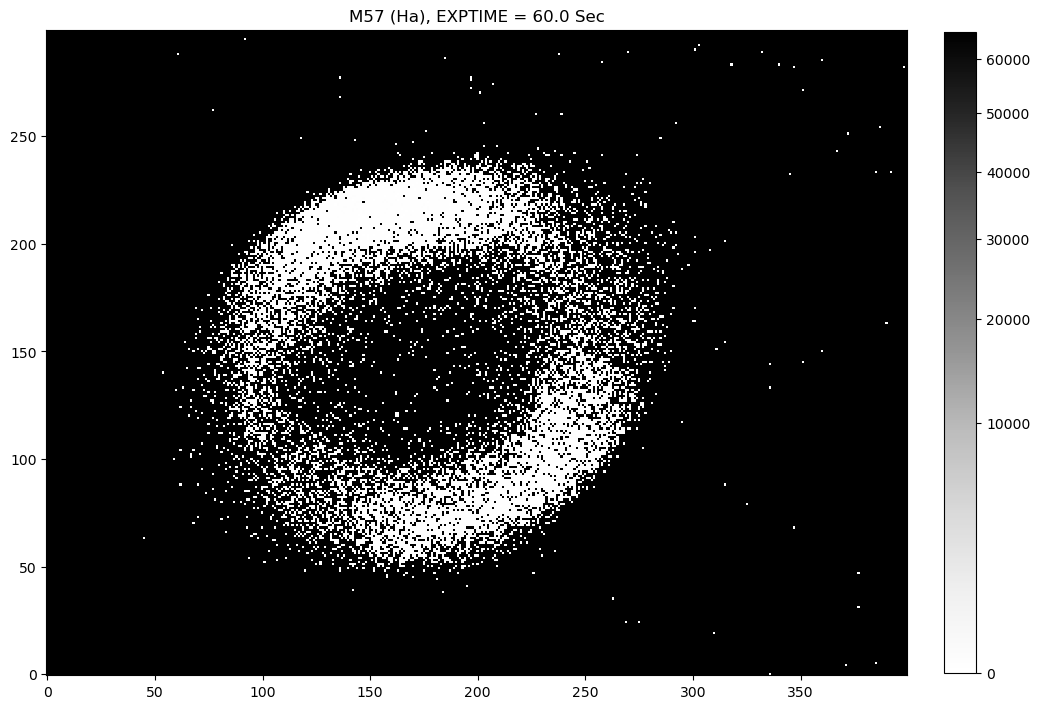

In [669]:
hdu = fits.open("M57/Ha-Filter-005-60s.fit")
hdr = hdu[0].header #to get exposure time
data = hdu[0].data[100:400, 800:1200] #full image is 512X2048
data = data - 98
#data = data_t
plt.figure(figsize=(12, 12))
norm = ImageNormalize(stretch=SqrtStretch()) #for imshow display
plt.imshow(data, cmap='Greys', origin='lower', interpolation='nearest', norm=norm) #vmax = 5 required to see the stars.
plt.title("M57 (Ha), EXPTIME = " + str(hdr['EXPTIME']) + " Sec")
im_ratio = data.shape[0]/data.shape[1] 
plt.colorbar(fraction=0.046*im_ratio, pad=0.04) #to scale colorbar to size of frame
plt.savefig("Figures/M57_Ha_plain")
hdu.close()

mean: 38666.19934166667 median: 65526.0 std: 32225.088537013027


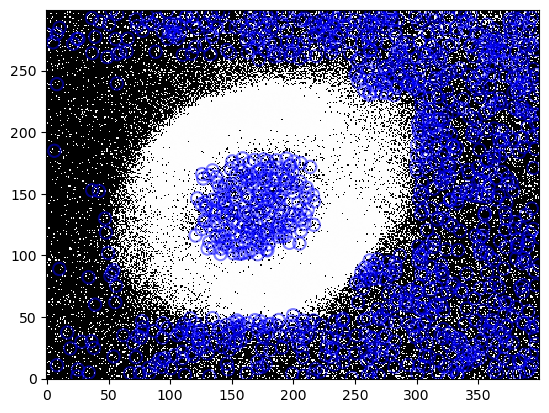

In [604]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print("mean: " + str(mean) + " median: " + str(median) + " std: " + str(std))
    # load the DAOStarFinder function. The FWHM tell it how to determine the radius of a star
    # the threshold helps determine when to ignore something and consider it not a star.

    # Give a high threshold, only brighter stars will be selected, a low threshold will circle nearly everything
threshold = 0.01 * std

    # this tells which size of PSF (size of star on image) that you want to circle. Give a high fwhm to circle larger PSF's
    # or in other words, larger stars. Give a small fwhm to circle smaller PSF's or 'smaller' stars.
fwhm = 3
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)

    # subtract the background from the imgage so the software doesn't get background light confused with stars
background_subracted_data = data - median

mask = np.zeros(data.shape, dtype=bool)
mask[50:100, 60:250] = True  # first excluded box
mask[100:200, 50:120] = True
mask[180:260, 60:250] = True
mask[100:230, 220:300] = True

sources = daofind(background_subracted_data, mask=mask)
circle_size = 5
    # So this just transposes the positions matrix so the data is in the right format for photutil
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    # This is a photutil function which draws circles around targets
apertures = CircularAperture(positions, r=circle_size)
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [591]:
mask = np.zeros_like(data, dtype=bool)
if sources is not None:
    for x, y in zip(sources['xcentroid'], sources['ycentroid']):
        yy, xx = np.ogrid[:data.shape[0], :data.shape[1]]
        r = np.sqrt((xx - x)**2 + (yy - y)**2)
        mask[r < 5*fwhm] = True

<photutils.segmentation.core.SegmentationImage>
shape: (300, 400)
nlabels: 52
labels: [ 1  2  3  4  5 ... 48 49 50 51 52]


Text(0.5, 1.0, 'Segmentation Image')

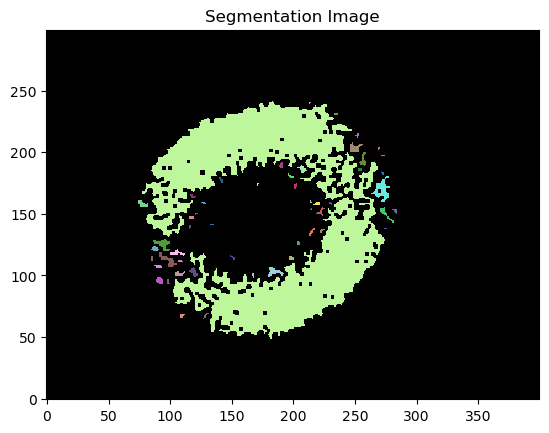

In [605]:
bkg_estimator = MedianBackground() # background estimation
bkg = Background2D(data, (200, 200), filter_size=(3, 3),
                bkg_estimator=bkg_estimator)
data = data.astype(float)
data -= 1.0 * bkg.background

threshold = 1.95 * bkg.background_rms

#convolve with kernel to increase S/N 
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

segment_map = detect_sources(-convolved_data, threshold, npixels=3) #10 connected pixels greater than threshold
print(segment_map)

plt.imshow(segment_map, origin='lower', cmap=segment_map.cmap,interpolation='nearest')
plt.savefig("Figures/M57Hasegmented")
plt.title('Segmentation Image')

In [594]:
cat = SourceCatalog(data, segment_map, convolved_data=-convolved_data) #photometry
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr   kron_flux    kron_fluxerr
                          ...                                            
----- --------- --------- ... --------------- -------------- ------------
    1    182.22    149.57 ...             nan -2887753101.17          nan
    2    129.00     67.22 ...             nan    -1761890.50          nan
    3    110.11     67.23 ...             nan    -1773708.67          nan
    4     91.70     95.45 ...             nan    -5018896.11          nan
    5     98.67     94.33 ...             nan    -1837846.91          nan
    6    167.67     99.83 ...             nan    -1125639.02          nan
    7    119.36    102.44 ...             nan    -5996462.71          nan
    8    184.97    102.57 ...             nan   -13352049.29          nan
    9    107.95    101.24 ...             nan    -5241047.51          nan
  ...       ...       ... ...             ...            ...          ...
   43    207.59    185.88 ...         

In [595]:
areas = [seg.area.value for seg in cat]
print(areas)
largest_label = np.argmax(areas) + 1
print(largest_label)

[np.float64(14576.0), np.float64(9.0), np.float64(9.0), np.float64(27.0), np.float64(9.0), np.float64(6.0), np.float64(30.0), np.float64(51.0), np.float64(21.0), np.float64(15.0), np.float64(57.0), np.float64(7.0), np.float64(8.0), np.float64(7.0), np.float64(11.0), np.float64(26.0), np.float64(18.0), np.float64(64.0), np.float64(5.0), np.float64(15.0), np.float64(8.0), np.float64(5.0), np.float64(3.0), np.float64(3.0), np.float64(34.0), np.float64(8.0), np.float64(20.0), np.float64(3.0), np.float64(10.0), np.float64(3.0), np.float64(27.0), np.float64(12.0), np.float64(4.0), np.float64(6.0), np.float64(3.0), np.float64(127.0), np.float64(9.0), np.float64(11.0), np.float64(3.0), np.float64(11.0), np.float64(11.0), np.float64(3.0), np.float64(24.0), np.float64(6.0), np.float64(11.0), np.float64(34.0), np.float64(3.0), np.float64(48.0), np.float64(3.0), np.float64(8.0), np.float64(6.0), np.float64(3.0)]
1


In [580]:
areas[22]

np.float64(3.0)

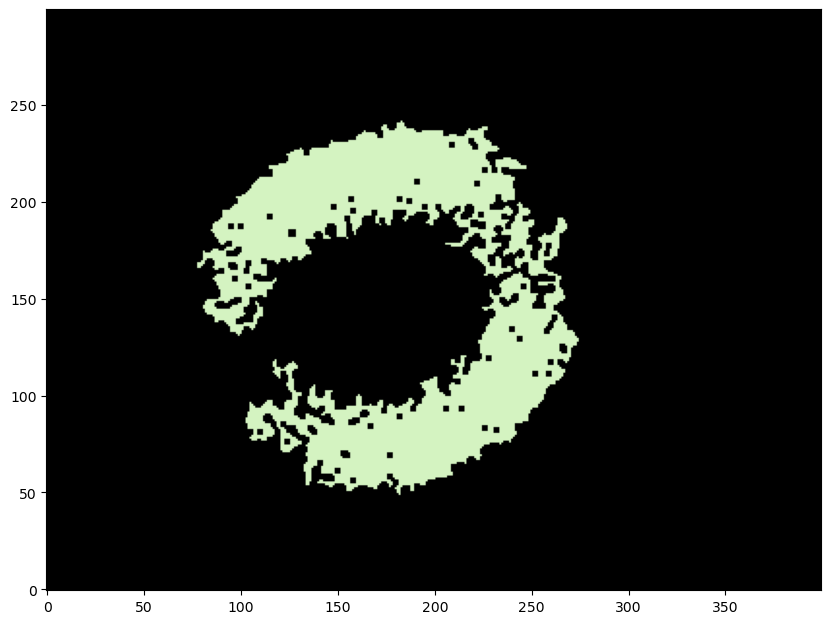

In [581]:
segment_map.keep_labels(labels=[1])

plt.figure(figsize=(10,10))
plt.imshow(segment_map, origin='lower', cmap=segment_map.cmap)
plt.show()

In [582]:
cat = SourceCatalog(data, segment_map, convolved_data=-convolved_data) #photometry
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr   kron_flux    kron_fluxerr
                          ...                                            
----- --------- --------- ... --------------- -------------- ------------
    1    182.22    149.57 ...             nan -2899874314.17          nan


In [629]:
i_Ha =  - tbl['kron_flux'][0] / hdr['EXPTIME']
print("i_Ha =", i_Ha)


i_Ha = 48129218.3527535


In [630]:
# to filter out stars can create a mask with the point sources found from DAOFind

In [665]:
F_Ha = (i_Ha / 245.73266666666666) * 1.67 * (4.792603650156814e-13)

In [666]:
F_Ha

np.float64(1.5675951107552787e-07)

## Question 2

In [638]:
D = 2.428 * 10 **21

In [644]:
j_Ha = (1.24 * 2.87) * 10**-25

In [659]:
V = 1.597 * 10**55

In [667]:
n_e = np.sqrt((4 * np.pi * D**2 * F_Ha) / (j_Ha * V))

In [668]:
n_e

np.float64(1429.4412663323274)

In [658]:
4/3 * np.pi * 3.93 * 10 **18 * (0.985 * 10 **18) **2

1.597179107740478e+55

In [657]:
1.97/2

0.985

In [664]:
F_Ha * 10**-23

np.float64(2.5242801434403854e-21)